# Working with PIFs
*Authors: Max Hutchinson, Carena Church, Enze Chen*

In this notebook, we introduce the Physical Information File, or **PIF**. We give a brief overview of the `pypif` Python package for interfacing with PIFs and motivate the topic with a real example of phase stability diagrams.

## Python package imports

In [1]:
# Standard packages
import re
import os

# Third-party packages
from pypif import pif
from dfttopif import directory_to_pif
from pypif_sdk.readview import ReadView
import matplotlib.pyplot as plt
%matplotlib inline

## What is a PIF?

The PIF is a __general__, __flexible__, and __hierachical__ schema, stored in JSON format, for representing infomation about physical devices and materials. This enables the PIF to store a wide range of information on many kinds of physical systems, but requires more careful thought on where to store information within the schema.

Writing analysis and post-processing on top of PIFs lets us:
 1. Pull in data from collaborators and published sources.
 1. Share our methodology with other researchers with data in PIFs.

## [`pypif`](https://github.com/CitrineInformatics/pypif/tree/master/pypif) package

The `pypif` package provides two APIs:
 1. Low level read/write API
 1. High[er] level read-only API

### Low level API

The low level API closely mirrors the [PIF schema definition](http://citrineinformatics.github.io/pif-documentation/schema_definition/index.html).

In [2]:
# Use helper method to import PIF object from JSON
pif = directory_to_pif("./example_data/Al.cF4")
print("The total energy is {} eV.".format(
        next(x for x in pif.properties if x.name == "Total Energy")
        .scalars[0].value
     ))

The total energy is -14.952228 eV.


Note that the `name` is a field in a properties object, so we are searching for the first [Property](http://citrineinformatics.github.io/pif-documentation/schema_definition/common/Property.html) with the `name` "Total Energy".

### High[er] level API: ReadView

It might be more natural to index the property by its name.  We provide a `ReadView` that wraps the PIF and provides such an index:

In [3]:
rv = ReadView(pif)
print(rv.keys())

dict_keys(['Converged', 'XC Functional', 'Relaxed', 'Cutoff Energy', 'k-Points per Reciprocal Atom', 'Pseudopotentials', 'Density Functional Theory', 'VASP', 'Total Energy', 'Pressure', 'Positions', 'Forces', 'positions', 'Density'])


We can easy obtain the chemical formula of the system as follows:

In [4]:
print("The chemical formula for this PIF is {}.".format(
        rv.chemical_formula))

The chemical formula for this PIF is Al4.


The `scalars` member of the [Property](http://citrineinformatics.github.io/pif-documentation/schema_definition/common/Property.html) contains the value of the property.  We also have access to metadata associated with that value, e.g. units:

In [5]:
print("The total energy is {} {}.".format(
        rv["Total Energy"].scalars[0].value,
        rv["Total Energy"].units)
     )

The total energy is -14.952228 eV.


## Real example: phase stability diagram

Let's make the `AlCu` phase diagram!  

### `enthalpy_of_formation`

First, we define the enthalpy of formation under ideal conditions:

In [6]:
def enthalpy_of_formation(energy, n_Al, n_Cu, energy_Al, energy_Cu):
    return (energy - n_Al * energy_Al - n_Cu * energy_Cu) / (n_Al + n_Cu)

### `get_stoich`
Next, a little chemical formula parser:

In [7]:
def get_stoich(AlCu_formula):
    m = re.match(r"Al([0-9]*)Cu([0-9]*)", AlCu_formula)
    if m is None:
        return (0, 0)
    
    n_Al = float(m.group(1)) if len(m.group(1)) > 0 else 1
    n_Cu = float(m.group(2)) if len(m.group(2)) > 0 else 1
    return (n_Al, n_Cu)

Next, we pull the values from some PIFs (the following code takes ~30 seconds):

In [8]:
Cu_pif = directory_to_pif("./example_data/Cu.cF4")
Al_pif = directory_to_pif("./example_data/Al.cF4")
AlCu_pifs = [directory_to_pif(os.path.join("./example_data/", x)) 
             for x in os.listdir("./example_data/") if "Al" in x]

energy_Al = ReadView(Al_pif)["Total Energy"].scalars[0].value / 4
energy_Cu = ReadView(Cu_pif)["Total Energy"].scalars[0].value

points = [(0.0, 0.0), (1.0, 0.0)]
for pif in AlCu_pifs:
    rv = ReadView(pif)
    energy = rv["Total Energy"].scalars[0].value
    n_Al, n_Cu = get_stoich(rv.chemical_formula)
    if n_Al == 0 and n_Cu == 0: continue
    points.append((
            n_Cu / (n_Cu + n_Al),
            enthalpy_of_formation(energy, n_Al, n_Cu, energy_Al, energy_Cu)
        ))

Finally, we plot the results:

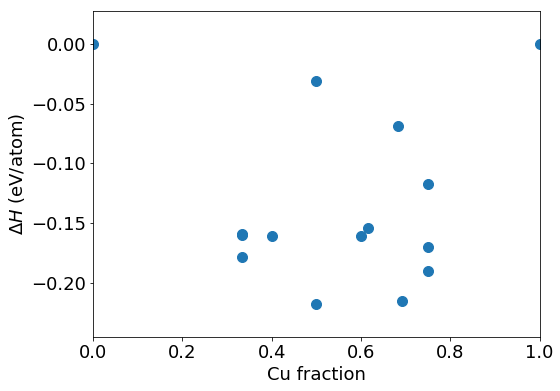

In [9]:
plt.rcParams.update({'font.size': 18, 'figure.figsize':(8, 6), 'lines.markersize':100})
plt.scatter(*zip(*points))
plt.xlim(0, 1)
plt.xlabel("Cu fraction")
plt.ylabel("$\Delta H$ (eV/atom)")
plt.show()

## Conclusion

This notebook gave a very brief introduction to the PIF structure and what kinds of data can be stored. A lot of details were kept hidden through the use of extra Python packages like [`pypif-sdk`](https://github.com/CitrineInformatics/pypif-sdk) and [`dfttopif`](http://citrineinformatics.github.io/pif-dft/dfttopif.html). For a more detailed breakdown of the PIF hierarchical format and [`pypif`](https://github.com/CitrineInformatics/pypif/tree/master/pypif) package, see the [Advanced tutorial on PIFs](AdvancedPif.ipynb).